In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import math


In [ ]:
# Load the dataset
file_path = "/kaggle/input/uber-fares-dataset/uber.csv"
df = pd.read_csv(file_path)

# Show first few rows
df.head()


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [18]:
# Display dataset information
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB
None


In [19]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [20]:
# Drop unnecessary columns
df.drop(columns=['Unnamed: 0', 'key'], inplace=True)

# Convert pickup_datetime to datetime format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Drop rows with missing or zero values
df = df.dropna()
df = df[
    (df['pickup_longitude'] != 0) & (df['pickup_latitude'] != 0) & 
    (df['dropoff_longitude'] != 0) & (df['dropoff_latitude'] != 0) & 
    (df['fare_amount'] > 0) & (df['passenger_count'] > 0)
]

# Check for missing values again
print(df.isnull().sum())

# Display dataset after cleaning
df.head()


fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5


In [21]:
from math import radians, sin, cos, sqrt, atan2

# Function to calculate haversine distance
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c  # Returns distance in km

# Apply haversine function to create a new column
df['distance_km'] = df.apply(lambda row: haversine_distance(
    row['pickup_latitude'], row['pickup_longitude'],
    row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

# Extract features from datetime
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year
df['day_of_week'] = df['pickup_datetime'].dt.weekday

# Drop pickup_datetime (not needed anymore)
df.drop(columns=['pickup_datetime'], inplace=True)

# Display dataset after feature engineering
df.head()


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,hour,day,month,year,day_of_week
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,19,7,5,2015,3
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,20,17,7,2009,4
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,21,24,8,2009,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,8,26,6,2009,4
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,17,28,8,2014,3


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


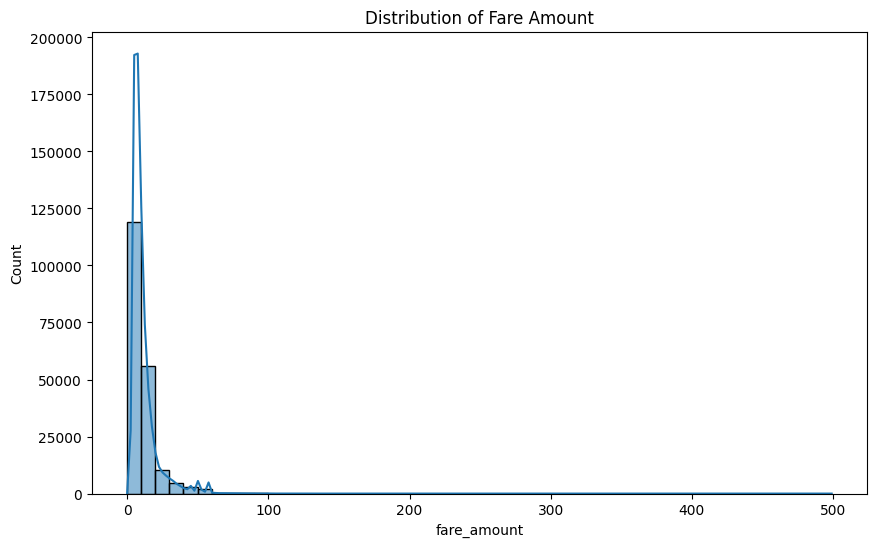

In [22]:
# Fare amount distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount')
plt.show()


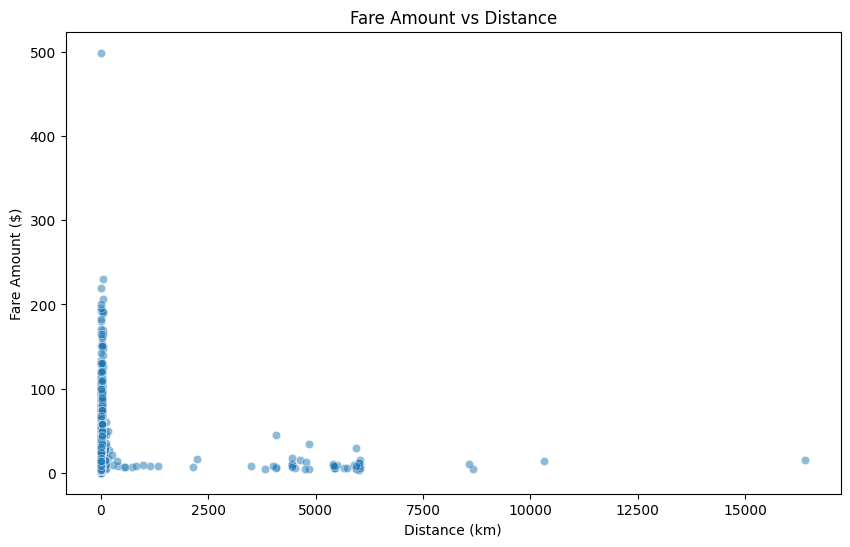

In [23]:
# Fare Amount vs Distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['distance_km'], y=df['fare_amount'], alpha=0.5)
plt.title('Fare Amount vs Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Fare Amount ($)')
plt.show()


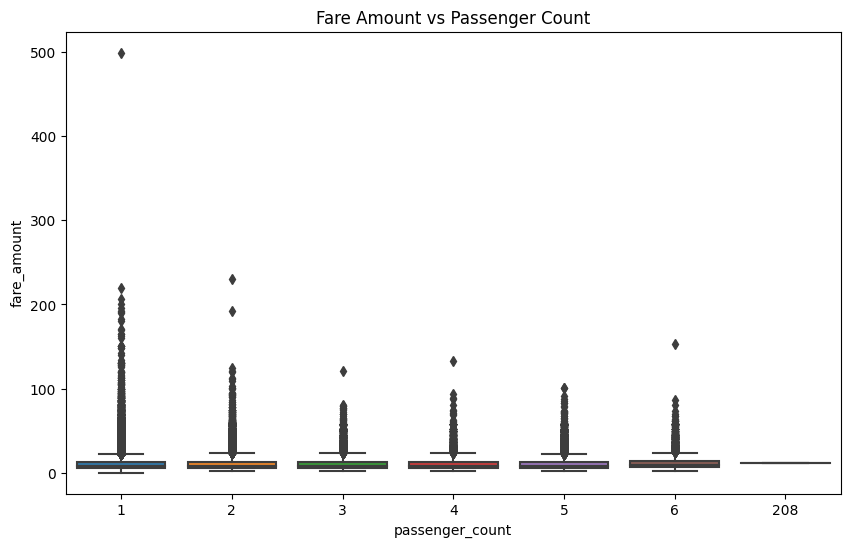

In [24]:
# Fare Amount vs Passenger Count
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['passenger_count'], y=df['fare_amount'])
plt.title('Fare Amount vs Passenger Count')
plt.show()


<ipython-input-25-d227979e9b98>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=df['hour'], y=df['fare_amount'], ci=None)


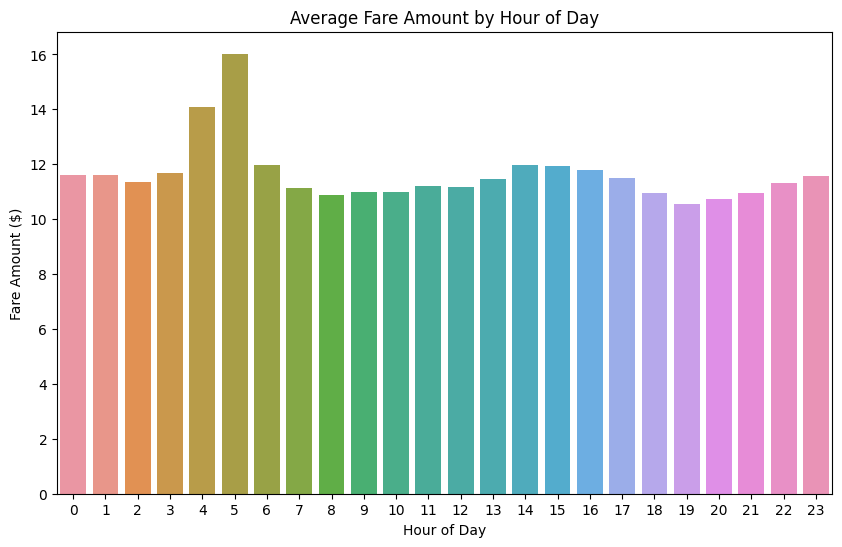

In [25]:
# Average Fare Amount by Hour of Day
plt.figure(figsize=(10, 6))
sns.barplot(x=df['hour'], y=df['fare_amount'], ci=None)
plt.title('Average Fare Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Fare Amount ($)')
plt.show()


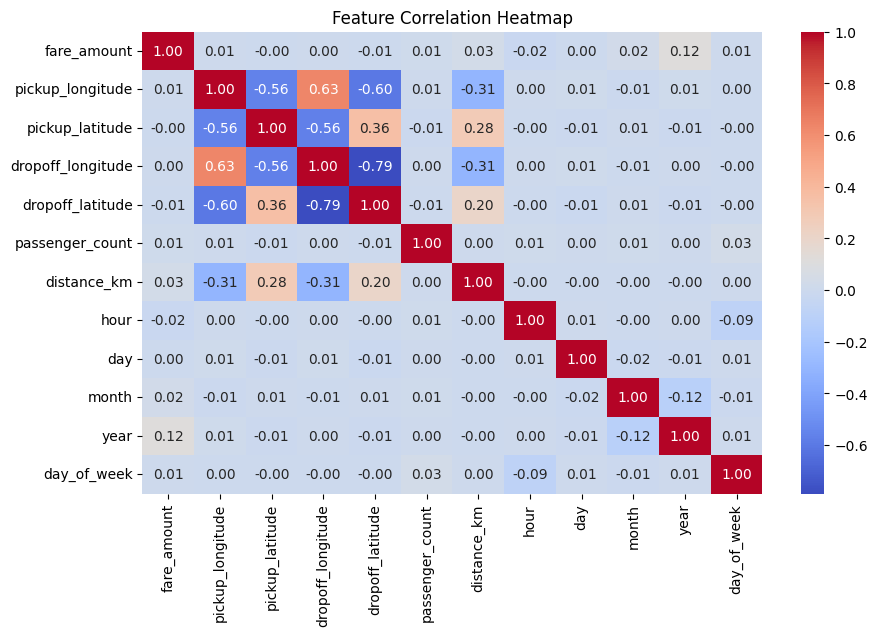

In [26]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()


In [6]:
# Define features and target
X = df.drop(columns=['fare_amount'])
y = df['fare_amount']

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data for better ML performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test_scaled)

# Model evaluation
print("Linear Regression Performance:")
print("R² Score:", r2_score(y_test, y_pred_lr))
print("RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))


Linear Regression Performance:
R² Score: 0.01827750503974246
RMSE: 9.662267973220835
MAE: 5.958957059514335


In [8]:
# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test_scaled)

# Model evaluation
print("Random Forest Performance:")
print("R² Score:", r2_score(y_test, y_pred_rf))
print("RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))


Random Forest Performance:
R² Score: 0.8299265265182181
RMSE: 4.0216382016020935
MAE: 1.8737077023498692


In [9]:
# Reshape data for LSTM input
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


In [10]:
# Define LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, validation_data=(X_test_lstm, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
4884/4884 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 100.0344 - val_loss: 87.8612
Epoch 2/20
4884/4884 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 56.5457 - val_loss: 25.0677
Epoch 3/20
4884/4884 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 27.3455 - val_loss: 24.0426
Epoch 4/20
4884/4884 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 27.2457 - val_loss: 23.8241
Epoch 5/20
4884/4884 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 26.9155 - val_loss: 22.3714
Epoch 6/20
4884/4884 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 25.6646 - val_loss: 21.9720
Epoch 7/20
4884/4884 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 26.6390 - val_loss: 22.3813
Epoch 8/20
4884/4884 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 24.2055 - val_loss: 22.1340
Epoch 9/20
4884/4884 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 27.7745 - val_loss: 21.6660
Epoch 10/20
4884/4884 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 23.1264 - val_loss: 22.4223
Epoch 11/20
4884/4884 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 23.0894 - val_loss: 21.5

In [11]:
# Predict and evaluate LSTM model
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Convert to 1D array
y_pred_lstm = y_pred_lstm.flatten()

# Model evaluation
print("LSTM Performance:")
print("R² Score:", r2_score(y_test, y_pred_lstm))
print("RMSE:", math.sqrt(mean_squared_error(y_test, y_pred_lstm)))
print("MAE:", mean_absolute_error(y_test, y_pred_lstm))


1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
LSTM Performance:
R² Score: 0.7816327414278506
RMSE: 4.556994115521027
MAE: 2.207501716152873


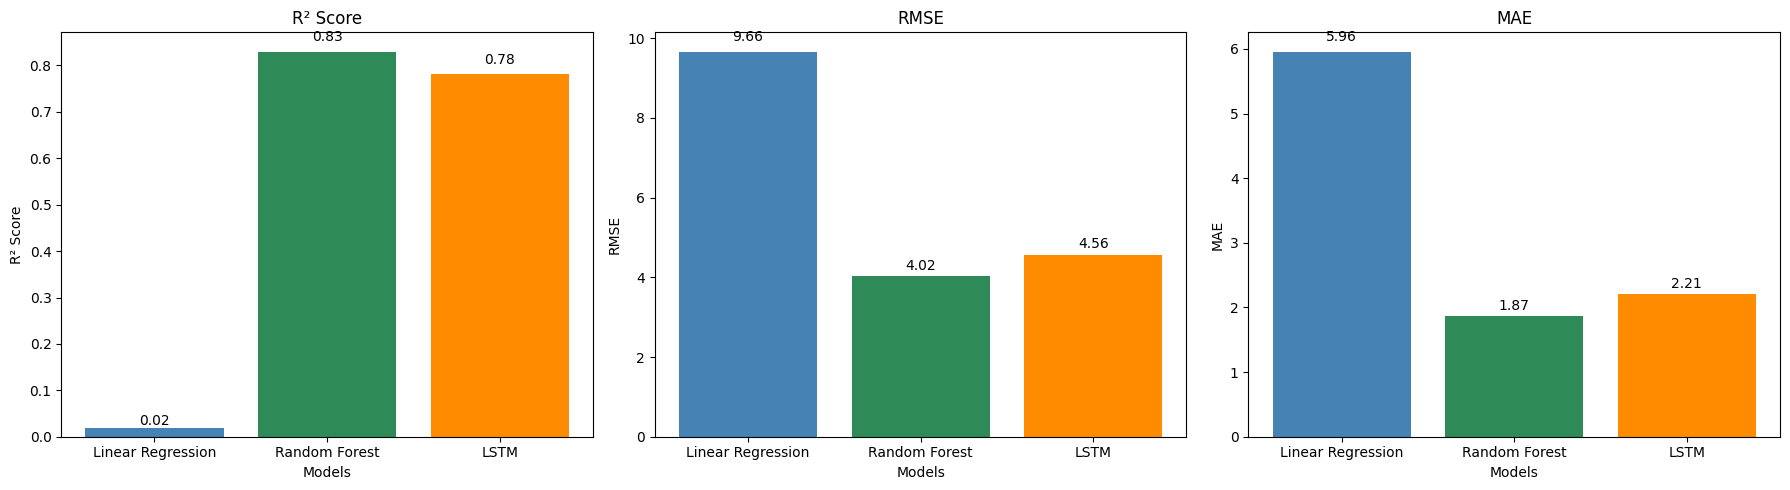

In [13]:
import matplotlib.pyplot as plt

# List of metrics to visualize
metrics = ['R² Score', 'RMSE', 'MAE']

# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    axes[i].bar(performance_df['Model'], performance_df[metric], color=['steelblue', 'seagreen', 'darkorange'])
    axes[i].set_title(metric)
    axes[i].set_xlabel("Models")
    axes[i].set_ylabel(metric)
    # Add value labels on top of each bar
    for index, value in enumerate(performance_df[metric]):
        axes[i].text(index, value + (value * 0.02), f"{value:.2f}", ha='center', va='bottom')
    
plt.tight_layout()
plt.show()
